In [70]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re

In [71]:
from utils.file_utils import get_experiment_df, get_experiment_configs_df
from utils.path_utils import visuals_folder
from plotlib.performance_plots import plot_standard_dev

In [72]:
sns.set_style("whitegrid")

## Path Selection

In [154]:
base_paths = []
full_data_paths = []

# CIFAR-10
# base_path = Path("/mnt/drive_nvme2/logs_cluster")
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_low"))
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_med"))
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_high"))
# full_data_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/cifar10/full_data/basic_model-resnet_drop-0_aug-cifar_randaugment_wd-0.0005_lr-0.1"))

# CIFAR-100
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100_low"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100_med"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100_high"))
# full_data_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/full_data/basic_model-resnet_drop-0_aug-cifar_randaugment_acq-random_ep-200"))

# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-standard"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100"))


# CIFAR-10 imb
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_low"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_med"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_high"))
# TODO
# full_data_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/full_data/basic_model-resnet_drop-0_aug-cifar_randaugment_acq-random_ep-200"))

# ISIC-2019
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_low"))
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med"))
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_high"))
full_data_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/full_data/basic_model-resnet_drop-0_aug-isic_train_wd-0.0005_lr-0.01"))

# Mio-TCD
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_low"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_med"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_high"))

## Run Selection

In [159]:
match_patterns = [
#     r"basic_.*",
    r"basic-pretrained_.*",
    r"fixmatch_.*",
#     r"fixmatch-pretrained_.*",
]

filter_patterns = [
#     ".*wd-0.01_.*"
#     r".*kcenter.*",
#     r".*variationratios.*"
]

## Style and Color Selection

In [160]:
hue_name = "Acquisition"

hue_split = "acq-"

style_name = "PreTraining & Semi-Supervised"
style_fct = lambda x: "PT: {}, Sem-SL: {}".format(
    "pretrained_model" in x.name,
    "fixmatch" in x.name
)

unit_vals = None
unit_name = "Unit"

## Fetch Data

In [161]:
dfs = []

for base_path in base_paths:
    paths = [path for path in base_path.iterdir() if path.is_dir()]
    paths.sort()
    print("Folders in Path: \n {}\n".format(base_path))

    
    experiment_paths = []
    for path in paths:
#         print(path)
        for pattern in match_patterns:
#             print(path.name)
            out = re.match(pattern, str(path.name))
            if out is not None:
                print(path.name)
                skip = False
                for filter_pattern in filter_patterns:
                    if re.match(filter_pattern, str(path)) is not None:
                        skip=True
                if skip:
                    continue

                print(path.name)
                experiment_paths.append(path)
                continue
                    


    hue_names = [path.name.split(hue_split)[1].split('_')[0] for path in experiment_paths]#.split('_')[0] for path in paths]
    style_vals = [style_fct(path) for path in experiment_paths]


    df = []
    for i, (base_dir) in enumerate(experiment_paths):
        base_dir = Path(base_dir)
        if hue_names is not None:
            hue_val = hue_names[i]
        else:
            hue_val = None
        if style_vals is not None:
            style_val = style_vals[i]
        else:
            style_val = None
        if unit_vals is not None:
            unit_val = unit_vals[i]
        else:
            unit_val = None

        experiment_frame = get_experiment_df(base_dir, name=hue_val)
        # experiment_frame[hue_name] = hue_val
        if experiment_frame is None:
            continue
        
        # Add new metric values
        experiment_add = get_experiment_df(base_dir, pattern="test_metrics.csv", name=hue_val)
#         print(experiment_add)
        if experiment_add is not None:
#             print(experiment_frame)
#             print(experiment_add)
            del experiment_add["Name"]
            del experiment_add["version"]
            experiment_frame = experiment_frame.join(experiment_add)
#             print(experiment_frame)
        
        
        experiment_frame[hue_name] = hue_val
        experiment_frame[style_name] = style_val
        experiment_frame[unit_name] = unit_val
        df.append(experiment_frame)
    df = pd.concat(df)
    df.reset_index(inplace=True)

    dfs.append(df)

Folders in Path: 
 /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_low

basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-random_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-random_ep-80_freeze-False_smallhead-False
Loading Experiment: /home/c817h/network/Cluster-Ex

In [162]:
full_data_dict = {}

for path in full_data_paths:
    test_acc_df = pd.read_csv(path/"test_acc.csv", index_col=0)
    full_data_dict["test_acc"]=dict()
    full_data_dict["test_acc"]["mean"] = float(test_acc_df["Mean"])
    full_data_dict["test_acc"]["std"] =  float(test_acc_df["STD"])
    
    if (path/"test_w_acc.csv").is_file():
        mean_recall_df = pd.read_csv(path/"test_w_acc.csv", index_col=0)
        full_data_dict["test/w_acc"]=dict()
        full_data_dict["test/w_acc"]["mean"] = float(mean_recall_df["Mean"])
        full_data_dict["test/w_acc"]["std"] =  float(mean_recall_df["STD"])

## Create Plot

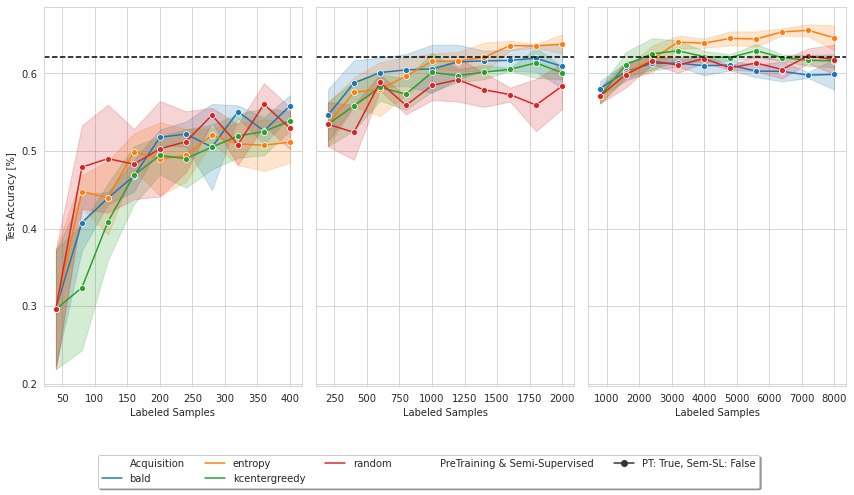

In [163]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend,
    )  # , units=unit_name)
    ax.axhline(full_data_dict["test_acc"]["mean"]/100, color="black", linestyle='--')
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Test Accuracy [%]")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

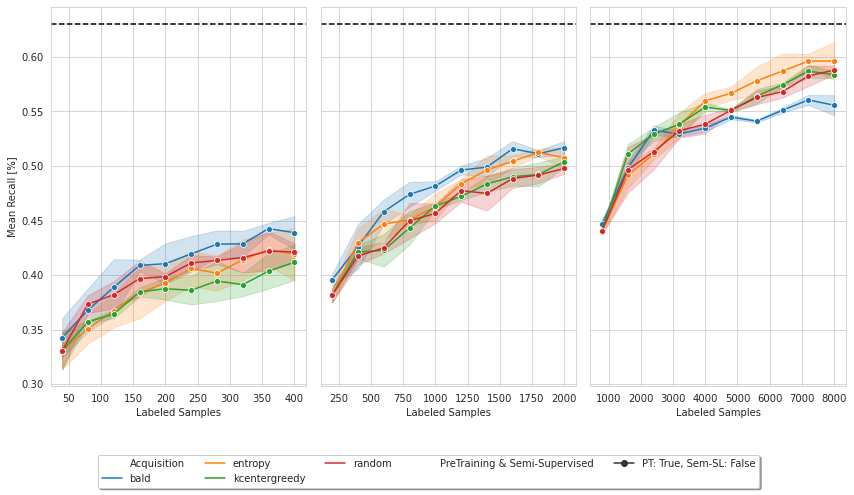

In [165]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend, y='test/w_acc'
    )  # , units=unit_name)
    ax.axhline(full_data_dict["test/w_acc"]["mean"]/100, color="black", linestyle='--')
    
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Mean Recall [%]")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

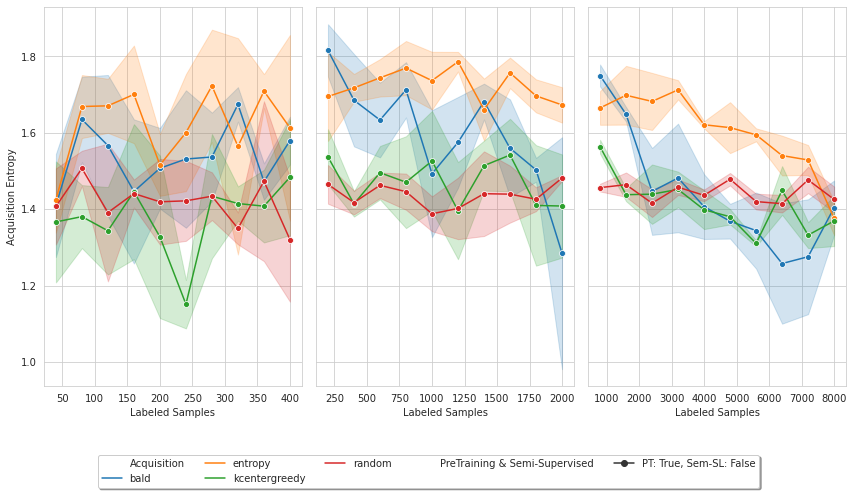

In [166]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend, y='Acquisition Entropy'
    )  # , units=unit_name)
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Acquisition Entropy")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

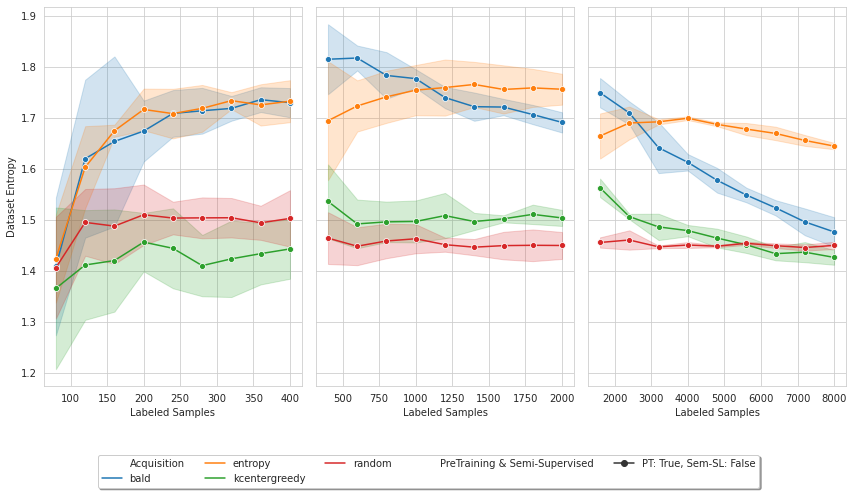

In [167]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend, y='Dataset Entropy'
    )  # , units=unit_name)
    ax.set_xlabel("Labeled Samples")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

In [11]:
dfs[2]

,index,val_acc,test_acc,num_samples,Acquisition Entropy,Dataset Entropy,version,Name,test/loss,test/auroc,test/av_prec,test/w_acc,test/av_f1,test/acc,Acquisition,PreTraining & Semi-Supervised,Unit
0,0,0.579100,0.592388,800,1.740990,NaN,9,bald,1.590337,0.851449,0.373815,0.450324,0.385501,0.592388,bald,"PT: True, Sem-SL: False",None
1,0,0.579100,0.592388,800,1.740990,NaN,9,bald,1.565121,0.844171,0.374958,0.442341,0.377238,0.577227,bald,"PT: True, Sem-SL: False",None
2,0,0.579100,0.592388,800,1.740990,NaN,9,bald,1.496194,0.848640,0.374909,0.448395,0.373232,0.571383,bald,"PT: True, Sem-SL: False",None
3,0,0.573309,0.577227,800,1.786608,NaN,9,bald,1.590337,0.851449,0.373815,0.450324,0.385501,0.592388,bald,"PT: True, Sem-SL: False",None
4,0,0.573309,0.577227,800,1.786608,NaN,9,bald,1.565121,0.844171,0.374958,0.442341,0.377238,0.577227,bald,"PT: True, Sem-SL: False",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,9,0.527244,0.528743,8000,1.389842,1.459136,9,random,1.408238,0.847061,0.340680,0.455579,0.333360,0.528743,random,"PT: False, Sem-SL: False",None
666,9,0.527244,0.528743,8000,1.389842,1.459136,9,random,1.331317,0.856902,0.375666,0.491650,0.363558,0.531112,random,"PT: False, Sem-SL: False",None
667,9,0.520663,0.531112,8000,1.419974,1.442971,9,random,1.371768,0.847303,0.352928,0.482221,0.331153,0.501895,random,"PT: False, Sem-SL: False",None
668,9,0.520663,0.531112,8000,1.419974,1.442971,9,random,1.408238,0.847061,0.340680,0.455579,0.333360,0.528743,random,"PT: False, Sem-SL: False",None


## Obtain Numerical Results

In [12]:
metric = "test_acc"

In [13]:
df = dfs[2]
df_random = df[df["Name"]=="random"]
# df_random = df.loc[:, ["test_acc", "num_samples", "PreTraining & Semi-Supervised"]]

In [14]:
for i in range(len(dfs)):
    df = dfs[i]
    df_random = df[df["Name"]=="random"]
    df_random = df_random.groupby(["num_samples", "PreTraining & Semi-Supervised"], ).agg({metric : ['mean', 'std']}).round(4)*100
    print(base_paths[i])
    print(df_random)

/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_low
                                          test_acc      
                                              mean   std
num_samples PreTraining & Semi-Supervised               
40          PT: False, Sem-SL: False         26.36  7.22
            PT: True, Sem-SL: False          29.60  7.73
80          PT: False, Sem-SL: False         38.44  2.51
            PT: True, Sem-SL: False          47.91  5.37
120         PT: False, Sem-SL: False         37.33  7.49
            PT: True, Sem-SL: False          49.01  6.96
160         PT: False, Sem-SL: False         40.96  1.37
            PT: True, Sem-SL: False          48.29  4.52
200         PT: False, Sem-SL: False         41.85  4.93
            PT: True, Sem-SL: False          50.27  6.14
240         PT: False, Sem-SL: False         40.77  2.75
            PT: True, Sem-SL: False          51.19  3.91
280         PT: False, Sem-SL: False         44.21  3.29
      